### Setup and Load Data ###

In [1]:
run ../initialize.ipynb

Lax Version : 1.5.2


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/seaborn-0.8.1-py3.4.egg/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


In [2]:
##Notebook Specific Setup Things
def cut_line(x, m, c):
    return m*x+c

In [3]:
def get_file_list(path, pattern, remove_string='', remove_path=True):
    '''
    Get a list of files matching pattern in path. Optional to remove a part of the path (i.e. the extention)
    Optional to remove the path
    '''
    file_list = glob.glob(path + pattern)
    # Remove path
    for i, f in enumerate(file_list):
        if remove_path:
            f = f.replace(path, '')
        if remove_string != '':
            f = f.replace(remove_string, '')
        file_list[i] = f
    file_list = np.sort(file_list)
    return file_list


### Find premade minitrees ###

In [4]:
datasets = hax.runs.datasets 
datasets = hax.runs.tags_selection(include=['*sciencerun1'],
                                  exclude=['bad','messy', 'test',
                                           'nofield','lowfield',
                                           'commissioning', 'flash',
                                           'pmttrip','trip','_pmttrip',
                                           'source_opening',
                                           ],
                                  )
datasets= hax.cuts.selection(datasets, datasets['location'] != '', 'Processed data available')

#Radon
datasets_rn = hax.cuts.selection(datasets, datasets['source__type']=='Rn220', 'Source in place')
dataset_names_rn = datasets_rn['name']

#Bkg
datasets_bkg = hax.cuts.selection(datasets, datasets['source__type']=='none', 'Source in place')
dataset_names_bkg = datasets_bkg['name']

#Krypton
datasets_kr = hax.cuts.selection(datasets, datasets['source__type']=='Kr83m', 'Source in place')
dataset_names_kr = datasets_kr['name']

Processed data available selection: 0 rows removed (100.00% passed)
Source in place selection: 7229 rows removed (4.56% passed)
Source in place selection: 1185 rows removed (84.35% passed)
Source in place selection: 7119 rows removed (6.01% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/cuts.py:125: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


In [7]:
dataset[:-17]

'170218_0950'

In [14]:
%%time
print('Radon Data')
#simpath= '/home/jpienaar/Test_files/'
simpath= '/scratch/midway2/jpienaar/cache_files/'

#Find datasets
datasets = get_file_list(simpath, '*Pre_trigger.hdf5', ' ')
print('Found %d datasets' % len(datasets))
n_files=len(datasets)

dfs_rn=[]
dfs_kr=[]
dfs_bkg=[]
for dataset in tqdm(datasets[:]):
    key=dataset[:-17]
    if dataset_names_rn.isin([dataset[:-17]]).any():
        if len(dfs_rn)<10:
            df = hax.minitrees.load(cache_file = simpath+dataset)
            dfs_rn.append(df)
              
    elif dataset_names_kr.isin([dataset[:-17]]).any():
        if len(dfs_kr)<15:
            df = hax.minitrees.load(cache_file = simpath+dataset)
            dfs_kr.append(df)
        
    elif dataset_names_bkg.isin([dataset[:-17]]).any():
        if len(dfs_bkg)<500:
            df = hax.minitrees.load(cache_file = simpath+dataset)
            dfs_bkg.append(df)

    
dfs_rn=pd.concat(dfs_rn)
dfs_kr=pd.concat(dfs_kr)
dfs_bkg=pd.concat(dfs_bkg)

  0%|          | 0/2287 [00:00<?, ?it/s]/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/minitrees.py:585: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  result.cut_history = store.get_storer('data').attrs.cut_history
  0%|          | 6/2287 [00:00<00:43, 52.25it/s]

Radon Data
Found 2287 datasets


100%|██████████| 2287/2287 [00:26<00:00, 84.96it/s]


CPU times: user 22.1 s, sys: 10.2 s, total: 32.2 s
Wall time: 38.3 s


In [15]:
dict_datasets = {'Radon': dfs_rn, 'Krypton': dfs_kr, 'Background': dfs_bkg}

In [16]:
print(len(dfs_kr), len(dfs_bkg), len(dfs_rn))

7511302 6728021 6230566


### Create Dicts for DFs ###

Krypton 7511302


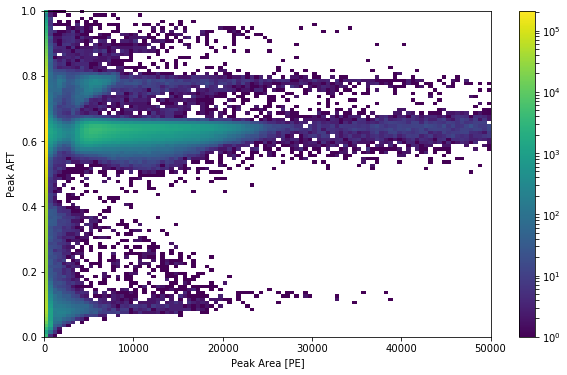

Radon 6230566


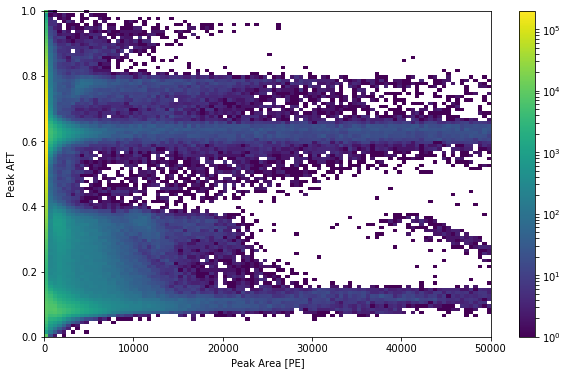

Background 6728021


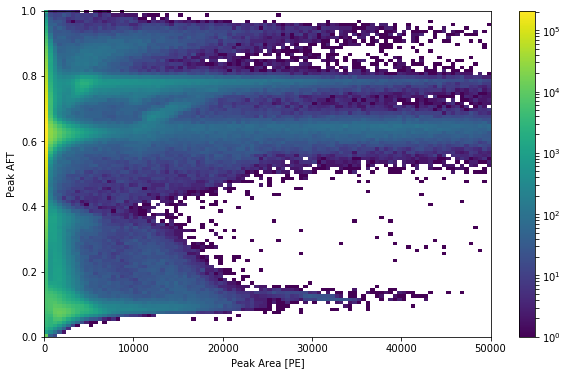

In [76]:
_xbins=100
_ybins=100
_x_lower=0
_x_upper=50000
_y_lower=0
_y_upper=1

_x_range=[_x_lower, _x_upper]
_y_range=[_y_lower, _y_upper]
for key, data in dict_datasets.items():
    print(key, len(data))
    fig=plt.figure(figsize=(10, 6))
    plt.hist2d(data.area, data.area_fraction_top, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm())
    plt.colorbar()
    plt.xlabel('Peak Area [PE]') 
    plt.ylabel('Peak AFT')
    #plt.savefig('confined_xy_%i.pdf' %index)
    #plt.savefig('confined_xy_%i.png' %index)
    plt.show()

In [4]:
with open('aft_fit_values.pkl', 'rb') as handle:
    dict_aft_fits = pickle.load(handle)

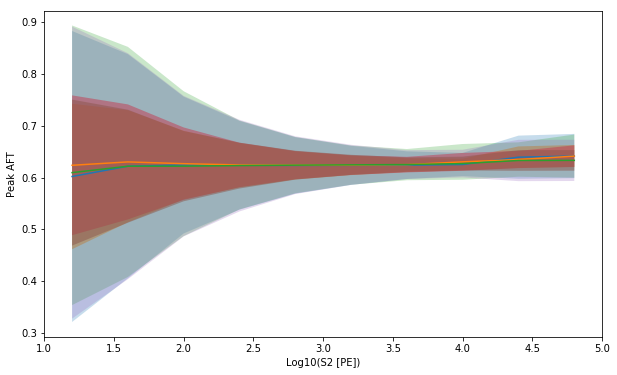

In [7]:
peak_size=np.linspace(1, 5, 11)
peak_bins=peak_size[:-1]+(peak_size[1:]-peak_size[:-1])/2

fig=plt.figure(figsize=(10, 6))
for key, dict_list in dict_aft_fits.items():
    plt.plot(peak_bins, dict_list['means'])
    peak_bins=dict_list['bins']
    # 3-sigma
    y1=np.array(dict_list['means'])-2*np.array(dict_list['sigmas'])
    y2=np.array(dict_list['means'])+2*np.array(dict_list['sigmas'])
    plt.fill_between(peak_bins, y1, y2, interpolate=True, alpha = 0.25)
    
    #2-sigma
    y1=np.array(dict_list['means'])-np.array(dict_list['sigmas'])
    y2=np.array(dict_list['means'])+np.array(dict_list['sigmas'])    
    plt.fill_between(peak_bins, y1, y2, interpolate=True, alpha = 0.5)
plt.xlim([1, 5])
plt.ylabel('Peak AFT')
plt.xlabel('Log10(S2 [PE])')
plt.show()

In [58]:
def aft_peak_cut(df):
    aft_means=np.array(dict_aft_fits['Background']['means'])
    aft_sigmas=np.array(dict_aft_fits['Background']['sigmas'])
    bins=dict_aft_fits['Background']['bins']
    df['CutPeakAFT']= True ^ (df.area_fraction_top>np.interp(np.log10(df.area), bins, aft_means-3*aft_sigmas)) ^ (df.area_fraction_top<np.interp(np.log10(df.area), bins, aft_means+3*aft_sigmas)) 
    return df

In [59]:
dict_datasets_test={}
for key, data in dict_datasets.items():
    data_test=aft_peak_cut(data)
    data_test=hax.cuts.selection(data, data['CutPeakAFT'], "CutPeakAFT")
    dict_datasets_test[key]=data_test

CutPeakAFT selection: 1162013 rows removed (84.53% passed)


/project/lgrandi/anaconda3/envs/pax_head/lib/python3.4/site-packages/hax-2.4.0-py3.4.egg/hax/cuts.py:125: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  d.cut_history = prev_cuts + [passthrough_dict]


CutPeakAFT selection: 503188 rows removed (91.92% passed)
CutPeakAFT selection: 1012473 rows removed (84.95% passed)


Krypton 6349289


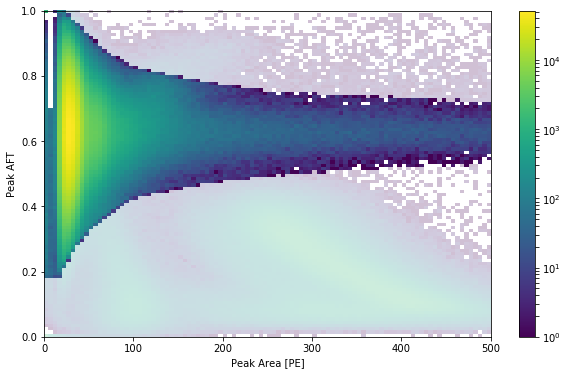

Radon 5727378


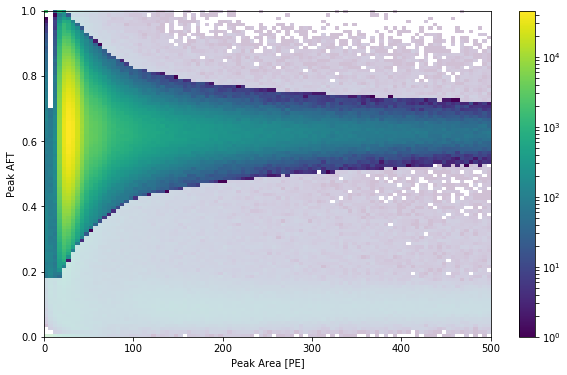

Background 5715548


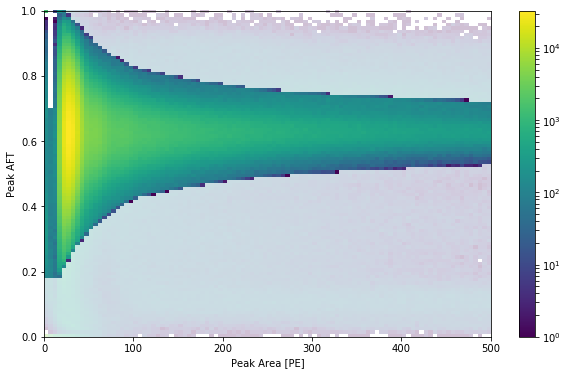

In [75]:
_xbins=100
_ybins=100
_x_lower=0
_x_upper=500
_y_lower=0
_y_upper=1

_x_range=[_x_lower, _x_upper]
_y_range=[_y_lower, _y_upper]
for key, data in dict_datasets_test.items():
    print(key, len(data))
    fig=plt.figure(figsize=(10, 6))
    data_all=dict_datasets[key]
    plt.hist2d(data_all.area, data_all.area_fraction_top, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm(), alpha=0.25)
    plt.hist2d(data.area, data.area_fraction_top, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm())
    plt.colorbar()
    plt.xlabel('Peak Area [PE]') 
    plt.ylabel('Peak AFT')
    #plt.savefig('confined_xy_%i.pdf' %index)
    #plt.savefig('confined_xy_%i.png' %index)
    plt.show()

Krypton 6349289


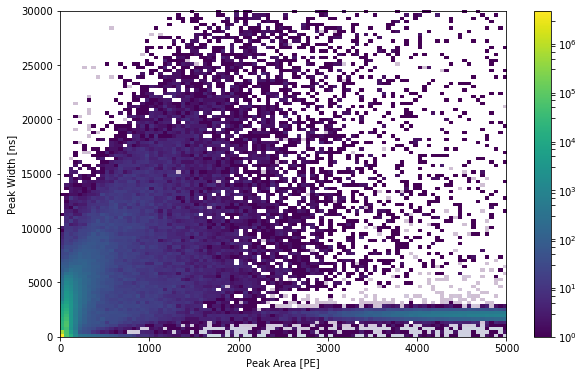

Radon 5727378


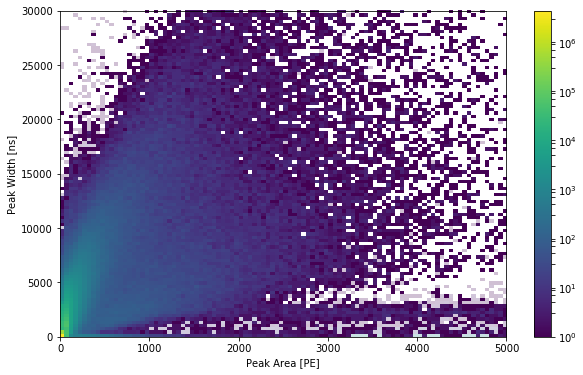

Background 5715548


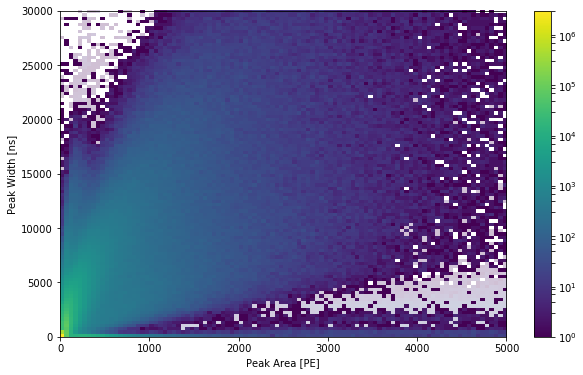

In [74]:
_xbins=100
_ybins=100
_x_lower=0
_x_upper=5000
_y_lower=0
_y_upper=30000

_x_range=[_x_lower, _x_upper]
_y_range=[_y_lower, _y_upper]
for key, data in dict_datasets_test.items():
    print(key, len(data))
    fig=plt.figure(figsize=(10, 6))
    data_all=dict_datasets[key]
    plt.hist2d(data_all.area, data_all.p_range_50p_area, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm(), alpha=0.25)
    plt.hist2d(data.area, data.p_range_50p_area, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm())
    plt.colorbar()
    plt.xlabel('Peak Area [PE]') 
    plt.ylabel('Peak Width [ns]')
    #plt.savefig('confined_xy_%i.pdf' %index)
    #plt.savefig('confined_xy_%i.png' %index)
    plt.show()

Krypton 6349289


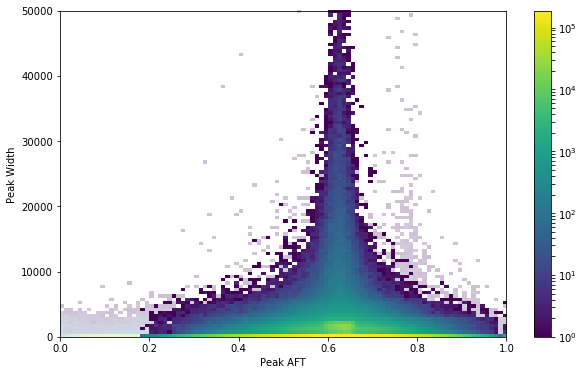

Radon 5727378


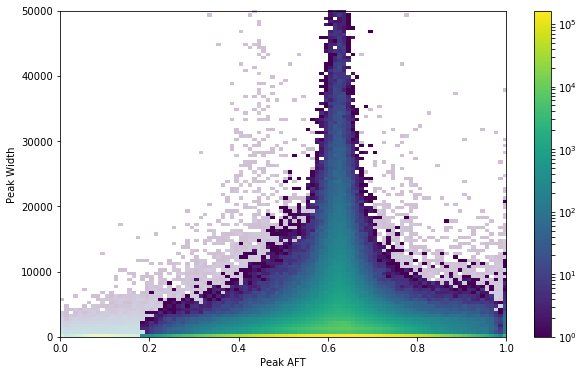

Background 5715548


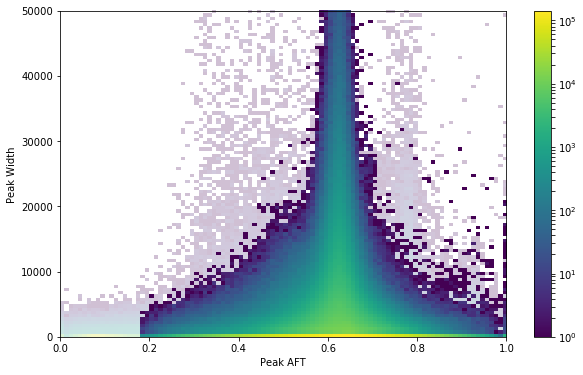

In [73]:
_xbins=100
_ybins=100
_x_lower=0
_x_upper=1
_y_lower=0
_y_upper=50000

_x_range=[_x_lower, _x_upper]
_y_range=[_y_lower, _y_upper]
for key, data in dict_datasets_test.items():
    print(key, len(data))
    fig=plt.figure(figsize=(10, 6))
    data_all=dict_datasets[key]
    plt.hist2d(data_all.area_fraction_top, data_all.p_range_50p_area, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm(), alpha=0.25)
    plt.hist2d(data.area_fraction_top, data.p_range_50p_area, bins=[_xbins, _ybins],
               range=[_x_range, _y_range], vmin=1, norm=LogNorm())
    plt.colorbar()
    plt.xlabel('Peak AFT') 
    plt.ylabel('Peak Width [ns]')
    #plt.savefig('confined_xy_%i.pdf' %index)
    #plt.savefig('confined_xy_%i.png' %index)
    plt.show()

### Cut Decisions

  * Use AFT cut as defined on 3-sigma bands